In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
import pathlib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve
import seaborn as sns
import datetime

In [2]:
# Load InceptionV3 model without the top layers
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model layers
base_model.trainable = False

87910968/87910968 [==============================] - 12s 0us/step


In [4]:
# Add new classification layers on top of the base model
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 23901985 (91.18 MB)
Trainable params: 2099201 (8.01 MB)
Non-trainable params: 21802784 (83.17 MB)
________

In [5]:
data_dir = 'dataset rembg'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.png')))
image_count

130

In [6]:
raw_durian_images_dict = {
    'ripe' : list(data_dir.glob('ripe/*')),
    'unripe' : list(data_dir.glob('unripe/*')),
} 
raw_durian_labels_dict = {
    'ripe' : 0,
    'unripe' : 1
}

In [7]:
X, y = [], []
image_input_shape = 299
output_folder = "resized_images"

for durian_ripeness, images in raw_durian_images_dict.items():
    for index, image in enumerate(images):
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(image_input_shape,image_input_shape))
        X.append(resized_img)
        y.append(raw_durian_labels_dict[durian_ripeness])

In [8]:
X = np.array(X)
y = np.array(y)

In [9]:
# Initial split to get training + validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

# Secondary split to get training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# Normalize / Rescale the pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [10]:
EPOCH = 100
BATCH_SIZE = 32
model_fit = model.fit(X_train, y_train, epochs=EPOCH, validation_data=(X_val, y_val), batch_size=BATCH_SIZE) 

Epoch 1/100
3/3 [==============================] - 24s 6s/step - loss: 1.0504 - accuracy: 0.5000 - val_loss: 1.0301 - val_accuracy: 0.4615
Epoch 2/100
3/3 [==============================] - 9s 3s/step - loss: 1.0987 - accuracy: 0.4872 - val_loss: 1.2392 - val_accuracy: 0.5385
Epoch 3/100
3/3 [==============================] - 9s 3s/step - loss: 0.8521 - accuracy: 0.6026 - val_loss: 0.9863 - val_accuracy: 0.4615
Epoch 4/100
3/3 [==============================] - 9s 3s/step - loss: 0.6759 - accuracy: 0.6667 - val_loss: 0.7217 - val_accuracy: 0.6923
Epoch 5/100
3/3 [==============================] - 9s 3s/step - loss: 0.5773 - accuracy: 0.7051 - val_loss: 0.8810 - val_accuracy: 0.6154
Epoch 6/100
3/3 [==============================] - 9s 3s/step - loss: 0.4319 - accuracy: 0.8077 - val_loss: 0.6486 - val_accuracy: 0.6154
Epoch 7/100
3/3 [==============================] - 9s 3s/step - loss: 0.5378 - accuracy: 0.6923 - val_loss: 0.6347 - val_accuracy: 0.6154
Epoch 8/100
3/3 [================

In [11]:
test_loss , test_accuracy = model.evaluate(X_test,y_test)
print(f'Model Accuracy: {test_accuracy}')

1/1 [==============================] - 2s 2s/step - loss: 1.0935 - accuracy: 0.7308
Model Accuracy: 0.7307692170143127


In [12]:
predictions = model.predict(X_test)
predictions = np.round(predictions,2)
predictions.flatten()

1/1 [==============================] - 5s 5s/step


array([0.9 , 0.07, 0.01, 0.19, 1.  , 0.04, 0.01, 0.  , 0.  , 0.97, 0.01,
       0.  , 0.01, 0.01, 0.  , 0.93, 0.89, 0.86, 0.97, 0.  , 0.06, 0.  ,
       0.  , 0.02, 0.01, 0.01], dtype=float32)

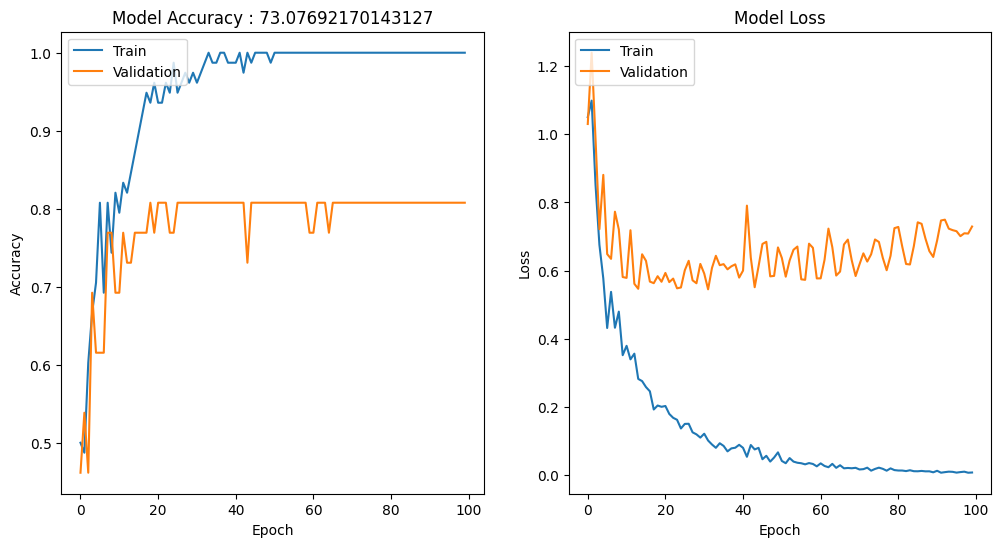

In [13]:
# Plot training and validation history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])  # Add validation accuracy
plt.title(f'Model Accuracy : {test_accuracy*100}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])  # Add validation loss
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Get current date and time
now = datetime.datetime.now()

# Format the date-time string as 'MMDDYYYY-HHMM'
date_time_str = now.strftime("%d%m%Y-%H%M%S")

# Save the plot with the specified name format
plt.savefig(f"{date_time_str}.png")
plt.show()

1/1 [==============================] - 4s 4s/step


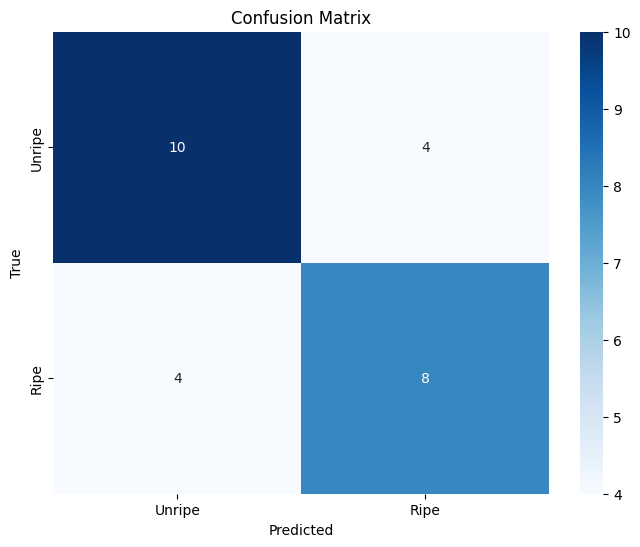

In [19]:
# Generate predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.01316).astype(int)  # Assuming it's a binary classification problem

# Generate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Unripe', 'Ripe'], yticklabels=['Unripe', 'Ripe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [15]:
# save model to .keras file
now = datetime.datetime.now()
# Format the date-time string as 'MMDDYYYY-HHMM'
date_time_str = now.strftime("%d%m%Y-%H%M%S")

In [16]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the TFLite model to a file
# with open(f'{date_time_str}.tflite', 'wb') as f:
#     f.write(tflite_model)

ROC and AUC to determine the most optimal threshold for Confussion Matrix \
Credit : https://www.youtube.com/watch?v=Joh3LOaG8Q0 (Dr. Sreenivas Bhattiprolu)

1/1 [==============================] - 4s 4s/step


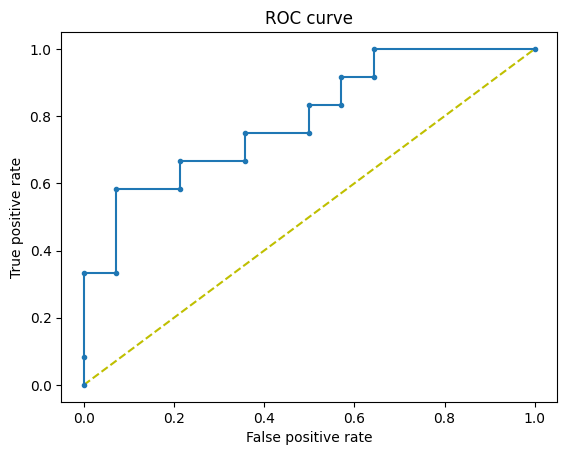

In [17]:
# Make predictions
y_preds = model.predict(X_test).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [18]:
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 

Ideal threshold is:  7    0.01316
Name: thresholds, dtype: float32
